In [2]:
import pandas as pd
import numpy as np
import datetime
import os
import fiona
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import mapping
import geopandas as gpd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# load the centerline file:
clinepath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/'
for file in os.listdir(clinepath):
    if file.endswith('.shp'):
        print(file)
cfile = 'centerline_n_utm07_500m_circlebuffer.shp'
print(); print(cfile, 'chosen')

if '_n_' in cfile:
    northline = True
    newfolder = 'centerline-north'
else:
    northline = False
    newfolder = 'centerline-south'
print(northline)

# read with geopandas
cline_gdf = gpd.read_file(clinepath+cfile)
geoms = cline_gdf.geometry.values
cline_gdf

centerline_s_utm07_250m_squarebuffer.shp
centerline_n_utm07_250m_circlebuffer.shp
centerline_n_utm07_250m.shp
centerline_n_utm07_250m_squarebuffer.shp
centerline_s_utm07_250m_circlebuffer.shp
centerline_s_utm07_500m_circlebuffer.shp
centerline_n_utm07_500m_circlebuffer.shp
centerline_n_utm07_121pts.shp
centerline_n_utm07_500m.shp
centerline_n_final_wgs84.shp
centerline_s_final_wgs84.shp
centerline_n_final_utm07.shp
centerline_s_final_utm07.shp
centerline_s_utm07_250m.shp

centerline_n_utm07_500m_circlebuffer.shp chosen
True


,id,distance,angle,geometry
0,None,0.0,120.762720,"POLYGON ((560899.262 6672656.883, 560887.026 6..."
1,None,500.0,120.762720,"POLYGON ((561328.909 6672401.141, 561316.673 6..."
2,None,1000.0,111.317912,"POLYGON ((561777.686 6672184.553, 561765.450 6..."
3,None,1500.0,106.858399,"POLYGON ((562246.083 6672010.320, 562233.847 6..."
4,None,2000.0,113.629378,"POLYGON ((562721.173 6671856.036, 562708.937 6..."
...,...,...,...,...
56,None,28000.0,119.124053,"POLYGON ((577652.493 6654803.399, 577640.257 6..."
57,None,28500.0,116.861918,"POLYGON ((578096.990 6654574.559, 578084.754 6..."
58,None,29000.0,119.116146,"POLYGON ((578538.770 6654340.605, 578526.534 6..."
59,None,29500.0,118.610460,"POLYGON ((578975.645 6654097.419, 578963.409 6..."


In [5]:
dem_diff_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/differenced_DEMs/sequential/'

# grab differenced DEM info:
ds1s = []; ds2s = []; fnames = []
for file in os.listdir(dem_diff_path):
    if file.endswith('.tif'):
        print(file)
        [ds1,ds2] = file.split('_') # split filename
        ds2 = ds2[:-4] # remove extension
        ds2s.append(ds1); ds1s.append(ds2); fnames.append(file)
dem_df = pd.DataFrame(list(zip(ds1s, ds2s, fnames)), columns=['ds1','ds2','fname'])
dem_df = dem_df.sort_values(by='ds1'); dem_df.reset_index(drop=True)

20160717_20151031.tif
20180507_20180128.tif
20210215_20200605.tif
20140318_20131207.tif
20190430_20180507.tif
20211025_20210717.tif
20210717_20210215.tif
20200605_20190430.tif
20180128_20160717.tif
20151031_20140318.tif
20220223_20211025.tif


,ds1,ds2,fname
0,20131207,20140318,20140318_20131207.tif
1,20140318,20151031,20151031_20140318.tif
2,20151031,20160717,20160717_20151031.tif
3,20160717,20180128,20180128_20160717.tif
4,20180128,20180507,20180507_20180128.tif
5,20180507,20190430,20190430_20180507.tif
6,20190430,20200605,20200605_20190430.tif
7,20200605,20210215,20210215_20200605.tif
8,20210215,20210717,20210717_20210215.tif
9,20210717,20211025,20211025_20210717.tif


# Extract elevation differences:

In [16]:
src

<open DatasetReader name='/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/differenced_DEMs/sequential/20180507_20180128.tif' mode='r'>

In [15]:
out_image.shape

(1, 251, 251)

20140318_20131207.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_36093/3666205671.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


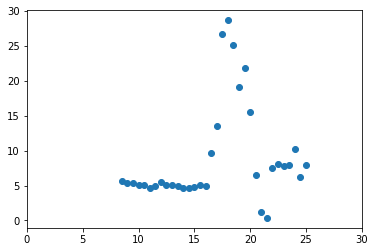

61
20151031_20140318.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_36093/3666205671.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


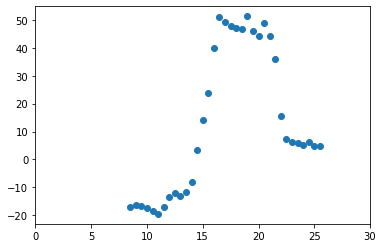

61
20160717_20151031.tif


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_36093/3666205671.py:15: RuntimeWarning: Mean of empty slice
  mean_diffs.append(np.nanmean(crop_array))


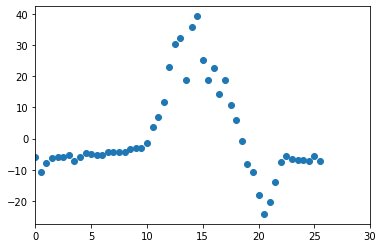

61
20180128_20160717.tif


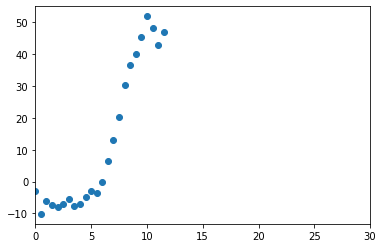

61
20180507_20180128.tif


KeyboardInterrupt: 

In [13]:
for idx, row in dem_df.iterrows():
        print(row.fname)
        src = rio.open(dem_diff_path+row.fname); elev_diff = src.read(1); affine=src.transform
        
        dists = []; mean_diffs = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e30] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_diffs.append(np.nanmean(crop_array))
            except Exception:
                mean_diffs.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_diffs = np.array(mean_diffs); dists = np.array(dists)
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
        mean_diffs[mean_diffs == 0] = np.NaN # differences should never be exactly 0
        plt.plot(dists/1000, mean_diffs, 'o')
        plt.xlim(0, 30)
        plt.show()
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_diffs)), columns=['dist_m','mean_elev_diff'])
        print(len(new_df))
        new_df.to_csv(dem_diff_path+newfolder+'/profile_'+row.ds1+'_'+row.ds2+'.csv')   

# Extract elevations:

In [8]:
dem_path = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/final-DEMs/'
dem_outpath = '/Users/jukesliu/Documents/TURNER/DATA/ICE_THICKNESS/surface/centerline_elevations/'
prof_count = 0


20140318


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


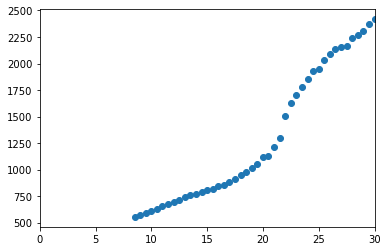

61
20220223


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


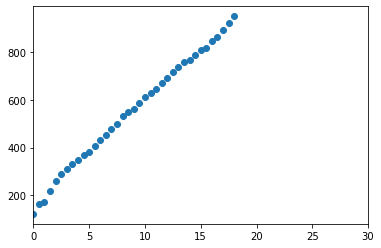

61
20180128


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


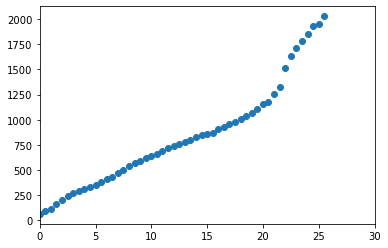

61
20180117


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


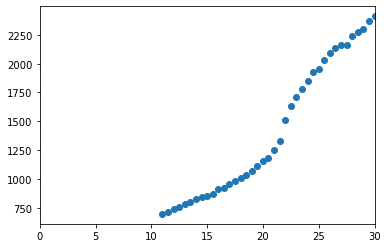

61
20220421


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


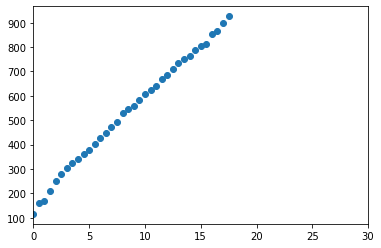

61
20220522


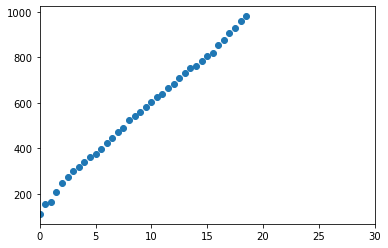

61
20190430


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


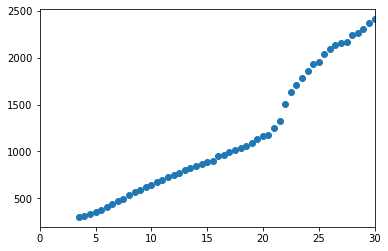

61
20151031


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


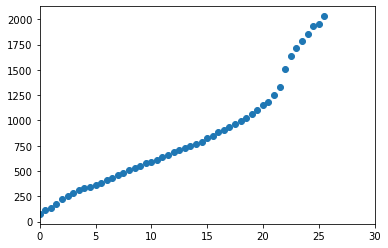

61
20131207


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


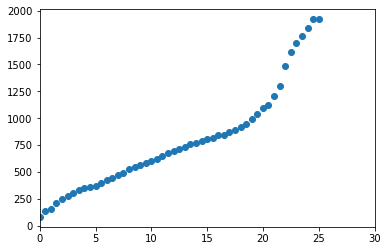

61
20180507


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


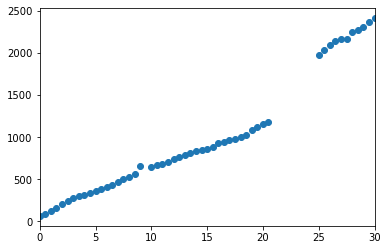

61
20200605


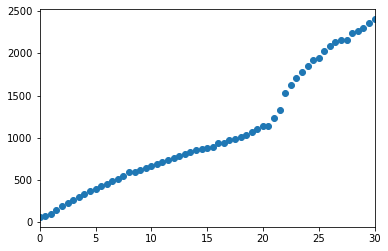

61
20160717


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


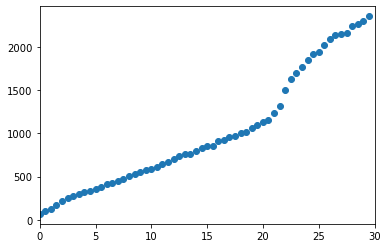

61
20210717


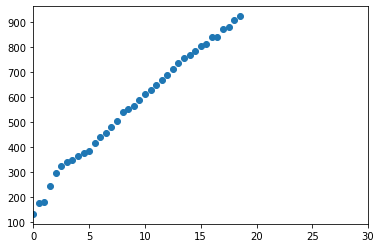

61
20211025


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_10422/2736091631.py:25: RuntimeWarning: Mean of empty slice
  mean_elev.append(np.nanmean(crop_array))


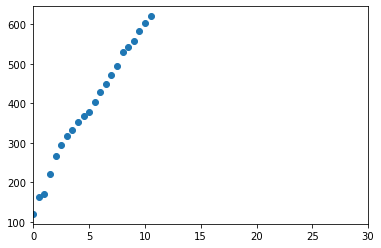

61


In [6]:
# pull DEM elevations
for file in os.listdir(dem_path):
    if file.endswith('UTM.tif'):
        ds = file.split('_')[0]
        print(ds)
        
        # open DEM
        src = rio.open(dem_path+file); elev = src.read(1); affine=src.transform
        
        # extract mean elevations
        dists = []; mean_elev = []
        for idx2, row2 in cline_gdf.iterrows():
            geom = row2.geometry
            dist = row2.distance
            dists.append(dist)
            try:
                out_image, out_transform = mask(src, [mapping(geom)], crop=True)
                crop_array = out_image[0,:,:]
                crop_array[crop_array < -1e3] = np.NaN
#                 print(dist, np.nanmean(crop_array))
                mean_elev.append(np.nanmean(crop_array))
            except Exception:
                mean_elev.append(np.NaN)
#                 print(dist, 'no overlap')
                pass
        mean_elev = np.array(mean_elev); dists = np.array(dists)
        if northline: # flip distances for northern centerline
            dists = np.flip(dists)
            
        
        mean_elev[mean_elev == 0] = np.NaN # differences should never be exactly 0
        plt.plot(dists/1000, mean_elev, 'o')
        plt.xlim(0, 30)
        plt.show()
        
        # write centerline data to csv
        new_df = pd.DataFrame(list(zip(dists, mean_elev)), columns=['dist_m','mean_elev'])
        print(len(new_df))
        new_df.to_csv(dem_outpath+'centerline_n_250m_'+ds+'.csv')
        
        prof_count+=1
# os.listdir(dem_path)

In [329]:
pd.to_datetime(date_list)

DatetimeIndex(['2013-12-07', '2014-03-18', '2015-10-31', '2016-07-17',
               '2018-01-17', '2018-01-28', '2018-05-07', '2019-04-30',
               '2020-06-05', '2021-07-17', '2021-10-25', '2022-02-23'],
              dtype='datetime64[ns]', freq=None)

2013-12-07 0.04321928507249165 2.101871991585408e-66
2014-03-18 0.037944785492995695 1.4296256569161442e-28
2015-10-31 0.04553135526592637 3.866894043166887e-73
2016-07-17 0.048855168029367416 7.410820032859029e-73
2018-01-28 0.0518338933377291 6.444778212338843e-68
2018-05-07 0.052073917288961116 1.0304373601948233e-66
2019-04-30 0.05382631450204082 3.5704605389761764e-62
2020-06-05 0.05314912423378142 1.8048201669464722e-57
2021-07-17 0.04031397933793334 3.02351432385069e-63
2021-10-25 0.04313317881779411 1.4884479858522432e-38
2022-02-23 0.04285195054085662 1.63407671156118e-69
0.0466120865381707


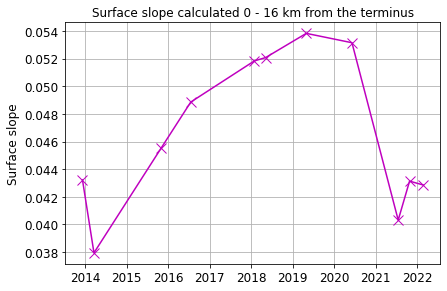

In [12]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
fs = 12
##########
outfigpath = '/Users/jukesliu/Documents/CONFERENCES/2022_IGS_Juneau/'
filelist = os.listdir(dem_outpath); filelist.sort()
#########

# colors
colors = plt.cm.viridis_r(np.linspace(0,1,prof_count))
col_count = 0

# plt.xlim(14,0)
# plt.ylim(-40,400)
plt.grid()
# plt.xlabel('Distance from terminus [km]',fontsize=fs)
# plt.ylabel('Elevation [m a.s.l.]',fontsize=fs)
plt.tick_params(labelsize=fs)
plt.tight_layout()

date_list = []; slopes = []
for elevprofile in filelist:
    if elevprofile.startswith('centerline_s_250m') and elevprofile.endswith('.csv'):
        elev_df = pd.read_csv(dem_outpath+elevprofile)
        ds = elevprofile.split('_')[-1][:-4]
        ds_leg = ds[0:4]+'-'+ds[4:6]+'-'+ds[6:8]
#         print(ds_leg)
        
    
        # EVALUATE SURFACE SLOPE AND PLOT
        if ds_leg != '2018-01-17': # incomplete
            surface_slope_df = elev_df[(elev_df.dist_m > 1e3) & (elev_df.dist_m < 16e3)] # between 1.5 and 14 km
            nanmask = ~np.isnan(surface_slope_df.mean_elev)
            
            if len(surface_slope_df.mean_elev[nanmask]) == 0:
                continu
            
            slope, intercept, r, p, std_err = stats.linregress(surface_slope_df.dist_m[nanmask], 
                                                               surface_slope_df.mean_elev[nanmask])  
            print(ds_leg, slope, p)
            slopes.append(slope)
            date_list.append(ds_leg)
#         plt.plot(surface_slope_df.dist_m/1000, surface_slope_df.dist_m*slope+intercept, color=colors[col_count])

        
#         # PLOT ELEVATION PROFILE
#         plt.plot(elev_df.dist_m/1000,elev_df.mean_elev, '-', linewidth=2.5, color=colors[col_count],alpha=0.8)
    
#         # save a figure:
#         plt.savefig(outfigpath+'elev_profile_nterm_'+ds+'.png',dpi=200)
            
        col_count+=1
        
# background_col='xkcd:white'; ax.set_facecolor(background_col)
# plt.gca().axes.get_xaxis().set_ticklabels([])
# plt.legend(date_list,ncol=3,loc='lower right',fontsize=fs, framealpha=1) # legend
plt.plot(pd.to_datetime(date_list), slopes, 'mx-', markersize=10)
plt.ylabel('Surface slope', fontsize=fs)
plt.title('Surface slope calculated 0 - 16 km from the terminus')

ss_df = pd.DataFrame(list(zip(date_list, slopes)), columns=['datetime','slope'])
# ss_df.to_csv(outfigpath+'surface_slopes_0to7km.csv')

print(np.nanmean(slopes))

plt.show()